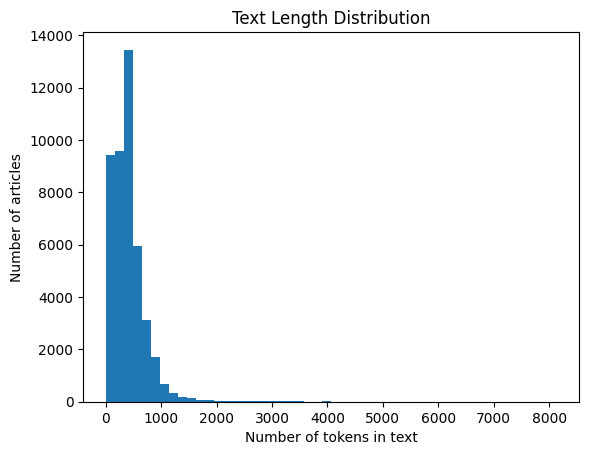

Total number of news: 44898


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

true_df = pd.read_csv('True.csv')
fake_df = pd.read_csv('Fake.csv')

true_df['label'] = 1
fake_df['label'] = 0

df = pd.concat([true_df, fake_df], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.to_csv('News.csv', index=False)

df['text_length'] = df['text'].astype(str).apply(lambda x: len(x.split()))

plt.hist(df['text_length'], bins=50)
plt.title('Text Length Distribution')
plt.xlabel('Number of tokens in text')
plt.ylabel('Number of articles')
plt.show()

print('Total number of news:', len(df))



c:\Users\15173\.conda\envs\fake_news_bert\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Token indices sequence length is longer than the specified maximum sequence length for this model (657 > 512). Running this sequence through the model will result in indexing errors


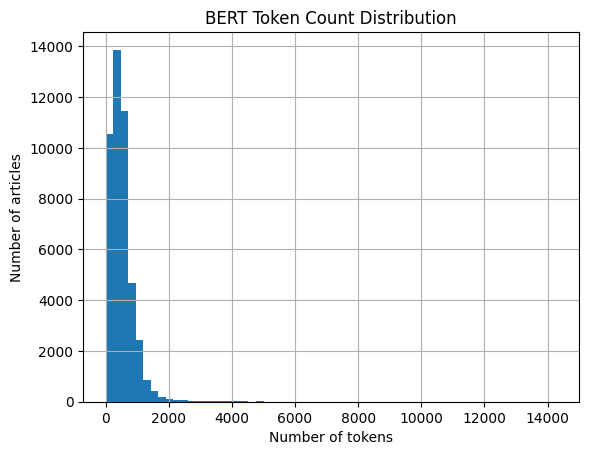

Max token length: 14285
Min token length: 2
Average token length: 510.61715443895054


In [3]:
from transformers import BertTokenizer


df = pd.read_csv('News.csv')
texts = df['text'].astype(str).tolist()

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
encoded = tokenizer(texts, padding=False, truncation=False, return_tensors='np')

lengths = [len(tokens) for tokens in encoded['input_ids']]

plt.hist(lengths, bins=60)
plt.title('BERT Token Count Distribution')
plt.xlabel('Number of tokens')
plt.ylabel('Number of articles')
plt.grid(True)
plt.show()

print('Max token length:', max(lengths))
print('Min token length:', min(lengths))
print('Average token length:', sum(lengths) / len(lengths))


In [4]:

import torch
from sklearn.model_selection import train_test_split


class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=max_len)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['label'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

df = pd.read_csv('News.csv')
texts = df['text'].astype(str).tolist()
labels = df['label'].tolist()

train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 512

train_dataset = NewsDataset(train_texts, train_labels, tokenizer, max_len)
test_dataset = NewsDataset(test_texts, test_labels, tokenizer, max_len)


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import string
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

df = pd.read_csv('News.csv')

def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

real_text = ' '.join(df[df['label'] == 1]['text'].astype(str).tolist())
fake_text = ' '.join(df[df['label'] == 0]['text'].astype(str).tolist())

real_clean = clean_text(real_text)
fake_clean = clean_text(fake_text)

real_wc = WordCloud(width=800, height=400, background_color='white').generate(real_clean)
fake_wc = WordCloud(width=800, height=400, background_color='white').generate(fake_clean)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.imshow(real_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Real News Word Cloud')

plt.subplot(1, 2, 2)
plt.imshow(fake_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Fake News Word Cloud')

plt.show()


In [9]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df = pd.read_csv("News.csv").sample(frac=1, random_state=42).reset_index(drop=True)
df_small = df.iloc[:1000]
texts = df_small['text'].astype(str).tolist()
labels = df_small['label'].tolist()

train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=max_len)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['label'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_texts, train_labels, tokenizer, max_len=512)
test_dataset = NewsDataset(test_texts, test_labels, tokenizer, max_len=512)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds),
        'recall': recall_score(labels, preds),
        'f1': f1_score(labels, preds)
    }

training_args = TrainingArguments(
    output_dir='./distilbert_output',
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    logging_dir='./logs',
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    save_total_limit=1
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

trainer.train()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\15173\.conda\envs\fake_news_bert\lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.125200,0.007356,1.000000,1.000000,1.000000,1.000000
2,0.017400,0.039895,0.995000,0.989899,1.000000,0.994924


TrainOutput(global_step=200, training_loss=0.07132921993732452, metrics={'train_runtime': 622.4243, 'train_samples_per_second': 6.426, 'train_steps_per_second': 0.803, 'total_flos': 211947837849600.0, 'train_loss': 0.07132921993732452, 'epoch': 2.0})

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       102
           1     1.0000    1.0000    1.0000        98

    accuracy                         1.0000       200
   macro avg     1.0000    1.0000    1.0000       200
weighted avg     1.0000    1.0000    1.0000       200



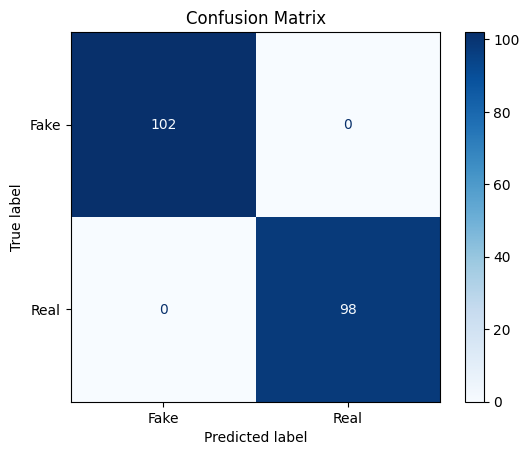

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()
